In [ ]:
#constellate: setup

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rho_plus as rho
import colour
import hsluv

IS_DARK = True
theme, cs = rho.mpl_setup(IS_DARK)
sns.palplot(cs)

: 

# A Field Guide to Color: Beyond RGB

Color rocks. Because color is so fundamental to how we process visual information, data visualization often relies on color for communicating information. (This isn't just graphs: traffic lights change color to help you know when to hit the gas, for example.) There are a surprising amount of difficulties that arise when trying to use color in the most accurate way possible. Let's investigate those, on a quest to create an optimal set of colors for data visualization.

## Color Theory

As with everything our brain does, color perception is a complex process. Let's start by setting the scene and covering the terminology and tools we'll need going forward. Consider this image:

![A sunset](https://i.imgur.com/iCzqRwP.jpg)

You see this image because tiny lights in your computer are turned on with the right intensities to reproduce what my camera recorded.[^1] How are those colors stored and represented, and how can we mathematically describe them?

[^1]: I'll get one disclaimer out of the way. You're probably not reading this on a color-calibrated monitor in the proper lighting conditions and distance, so the colors you see are almost certainly not what my camera recorded. They're pretty close, though. If you have something like a night light mode turned on, I'd recommend turning it off to view this piece.

### Color Dimensions

Humans see color in three[^1] dimensions. If you set up three different primary-color lamps, such that their intensities are controllable, and then ask participants to match a given color, people can always find a matching configuration, and moreover different people will roughly come up with the same answer.[^2] I've replicated the basic idea on the right: you can try matching a particular color using different intensities of red, green, and blue.

[^1]: This is not strictly true. Certain kinds of color blindness can reduce the number of different dimensions available, and some people are *tetrachromats* and have another dimension to see with. We're going to be eliding over some of these details.

[^2]: This data, which was very important in defining the first color spaces, comes from the 1920s experiments conducted by Wright and Guild. There are some details here that I'm skipping: feel free to investigate on your own.

In [293]:
#constellate: setup_panel

import param
import panel as pn
import bokeh
import matplotlib.colors as mpl_colors
from bokeh.plotting import Figure
import matplotlib.figure as figure

pn.extension()

class ThemedParam(param.Parameterized):
    colorMode = param.ObjectSelector(["dark", "light"], precedence=-1)

    def __init__(self):
        super().__init__()
        if 'colorMode' in pn.state.session_args:
            self.colorMode = pn.state.session_args["colorMode"][0].decode().lower()
        else:
            self.colorMode = 'dark'

    @pn.depends("colorMode")
    def colors_theme(self):
        mpl_theme, colors = rho.mpl_setup(self.colorMode == 'dark')
        plt.style.use(mpl_theme)
        theme = 'dark_minimal' if self.colorMode == 'dark' else 'light_minimal'
        return (colors, mpl_theme, theme)

In [294]:
class WrightGuild(ThemedParam):
    target = param.Color(default=cs[0])
    r = param.Integer(30, bounds=(0, 255), label='Red')
    g = param.Integer(10, bounds=(0, 255), label='Green')
    b = param.Integer(40, bounds=(0, 255), label='Blue')

    @pn.depends('r', 'g', 'b')
    def rgb(self):
        return mpl_colors.to_hex((self.r / 255, self.g / 255, self.b / 255))

    @pn.depends('target', 'r', 'g', 'b')
    def plot(self):
        colors, mplt, theme = self.colors_theme()
        p: Figure = Figure(background_fill_color=self.target, x_range=(0, 10), y_range=(0, 10), sizing_mode='scale_both')

        p.rect(x=2.5, y=5, width=5, height=10, color=self.target)
        p.rect(x=7.5, y=5, width=5, height=10, color=self.rgb())
        
        return pn.pane.Bokeh(p, theme=theme, sizing_mode='scale_both')


mod = WrightGuild()
app = pn.Row(mod.plot, mod.param)
app.servable('Color Matching')

BokehModel(combine_events=True, render_bundle={'docs_json': {'825918ef-2fd5-4ab7-83f5-126b9f16c276': {'defs': …

Row
    [0] ParamMethod(method)
    [1] Column(margin=5, name='WrightGuild', width=300)
        [0] StaticText(value='<b>WrightGuild</b>')
        [1] ColorPicker(name='Target', value='#7075ff')
        [2] IntSlider(end=255, name='Red', value=30)
        [3] IntSlider(end=255, name='Green', value=10)
        [4] IntSlider(end=255, name='Blue', value=40)

### Hue

We see color in three dimensions, but there are several sets of three dimensions that work. Primary colors are just one possible trio. Another trio, which has independent usefulness, includes *hue*, *saturation*, and *lightness*.

Hue is where we place a color on the rainbow, and corresponds with the wavelength of light. Most of our basic color terminology is about hue: red, orange, green, blue, purple, etc., are all mainly specifying the hue.

Rather interestingly, hue forms a cycle: it's best described as a *color wheel*, as depicted to the right.

This may not sound especially groundbreaking, but even here there's some subtlety you may not think about all the time. One note is that yellow and brown aren't necessarily different hues: instead of, say, red, with dark red and light red both being called, well, red, we have a special word for dark yellow that obscures their relationship. Black and white don't have a hue, which means they're desaturated. What does that mean?

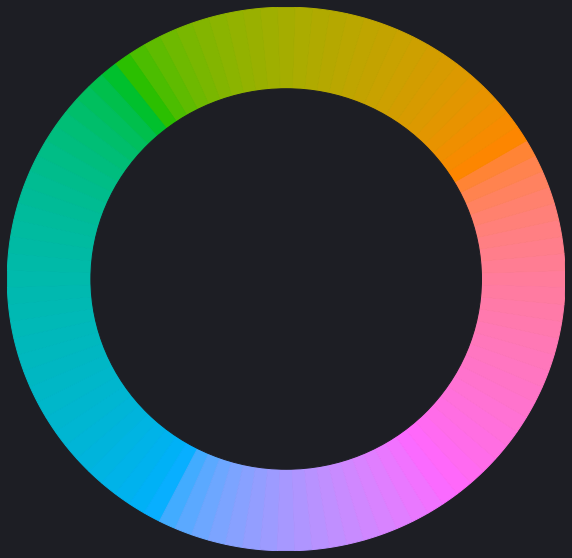

In [295]:
from matplotlib.patches import Wedge, Circle

fig, ax = plt.subplots(figsize=(10, 10))


ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
hh, dh = np.linspace(0, 360, 100, endpoint=False, retstep=True)
for h in hh:
    s = 100
    l = 68
    color = hsluv.hsluv_to_rgb([h, s, l])
        
    wf = Wedge((0, 0), s, h - 0.5 * dh, h + 0.5 * dh, color=color)    
    ax.add_patch(wf)

ax.add_patch(Circle((0, 0), radius=0.7 * s, color=plt.rcParams['axes.facecolor']))
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

## Saturation

Saturation is defined as how strongly a color embodies its particular hue. Shades of gray, which come from light that is equally distributed among the different wavelengths, have no saturation. The maximal saturation comes from spectral light: light that is entirely of a single wavelength, as comes out of lasers.

Saturation is a linear scale with a lot of complexity behind it. We're going to come back to this later, and for now I'll just show a couple gradients with increasing saturation.

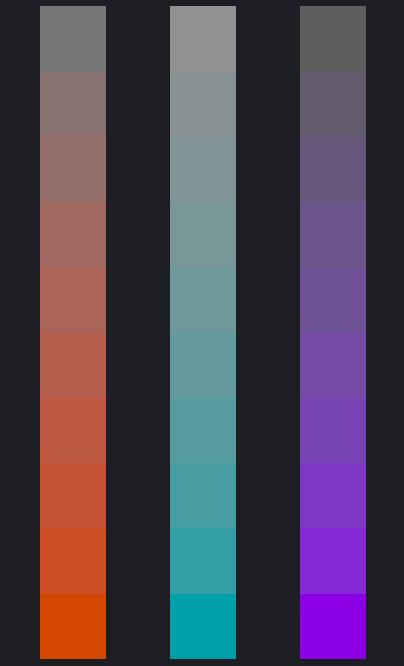

In [296]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(7, 12))

hues = (20, 200, 280)
lums = (50, 60, 40)
w = 10

ss, ds = np.linspace(0, 100, 10, retstep=True)
for s in ss:
    for i, (h, l) in enumerate(zip(hues, lums)):
        color = hsluv.hsluv_to_rgb([h, s, l])
        ax.add_patch(Rectangle((w + w * 2 * i, 100 - s), w, ds, color=color))

ax.set_ylim(0, 100 + ds)
ax.set_xlim(w * 0.5, w * 6.5)
ax.set_frame_on(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

## Lightness

Last but certainly not least, we have lightness. Physically, lightness comes from how much light a surface emits, either by reflecting it (like paint on a wall with color you can only see when the lights are on) or by emitting it directly (as the lights behind the screen you're reading this on!)

There's a lot more to the story. There is a difference of roughly 15 orders of magnitude between the dimmest light you can detect and a light bright enough to cause optic damage. If we perceived the sun going behind a cloud as causing a tenfold reduction in lightness, even if that's what happens physically, it'd be quite difficult for us to process the world around us. As such, we have a very sharp eye for small differences between shades of black that then tapers off dramatically. There's no magic formula for this, but I've graphed one attempt to describe this behavior opposite.[^1] A gray that reflects 50% of the available light, when placed in a sequence by humans, will be around 18% of the way from black to white.[^1]

Perceived lightness depends on surroundings and many other factors, as many optical illusions demonstrate. We won't focus on that too much right now.

[^1]: The formula I use is the CIE 1976 equation, still widely used today.

[^2]: One nifty application of this knowledge is *gamma correction*. When storing colors in computers, putting the lightness on an exponential scale is more efficient, because it means that you're roughly equally distibruting the colors you can render over the colors people can actually see, and not wasting data with many very similar colors while leaving other areas sparse.

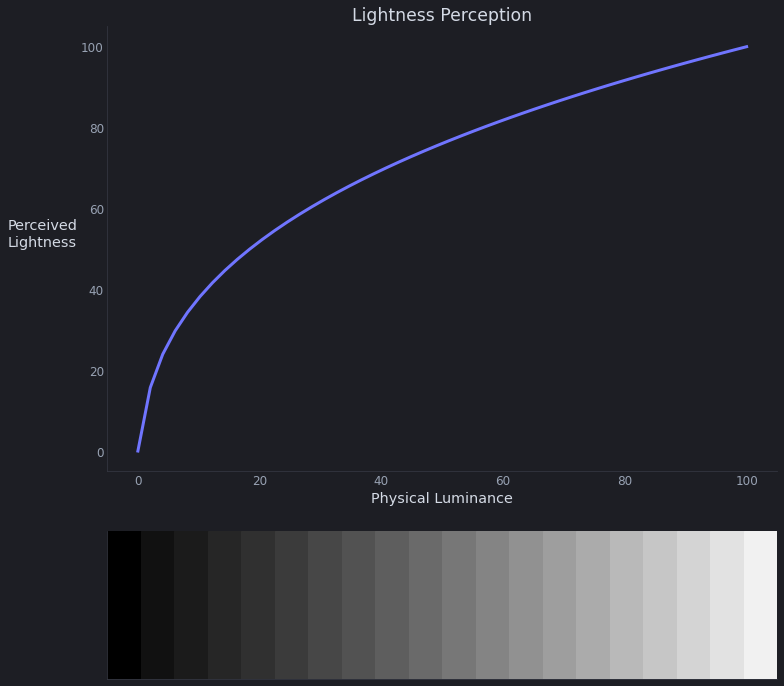

In [297]:
from matplotlib.patches import Rectangle

def f(t):
    '''CIELAB luminance formula.'''
    t = np.array(t)
    c = (6 / 29) ** 3
    return np.where(t > c, np.cbrt(t), (c ** -2 / 3) * t + 4 / 29)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw=dict(height_ratios=(3, 1)))

xx = np.linspace(0, 100)
yy = 116 * f(xx / 100) - 16
ax1.plot(xx, yy)
ax1.set_ylabel('Perceived\nLightness', ha='right', rotation='horizontal')
ax1.set_xlabel('Physical Luminance')
ax1.set_title('Lightness Perception')

ll, dl = np.linspace(0, 100, 20, endpoint=False, retstep=True)
for l in ll:
    ax2.add_patch(Rectangle((l, 0), dl, 1, color=hsluv.hsluv_to_hex([0, 0, l])))
ax2.set_xlim(0, 100)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)

## Representing Color

It'd certainly be nice to have a color system that let us specify a color using its hue, saturation, and lightness. However, this isn't quite as simple as it seems for a couple important reasons.

The biggest reason is that saturation and lightness aren't really independent. White and black are desaturated by definition, and there's no such thing as a very dark neon green for example.

We have three different cone receptors in our eyes that perceive red, green, and blue. The green receptors correlate most with perceived lightness, so colors with green in them can only be highly saturated when light. Similarly, colors like red, blue, and purple are most saturated when dark: a light purple requires adding some green, which reduces saturation.

In [298]:
#constellate: setup
def hex2oklch(hexs):
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):
        lchs = []
        if isinstance(hexs, str):
            hexs = [hexs]
        for hex in hexs:
            L, a, b = colour.convert(hsluv.hex_to_rgb(hex), 'sRGB', 'Oklab')
            h = np.rad2deg(np.arctan2(b, a)) % 360
            c = np.hypot(b, a)
            lchs.append(np.array([L, c, h]))

        return np.array(lchs)

def oklch2hex(oklch):
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):
        return np.array([
            hsluv.rgb_to_hex(np.clip(colour.convert((L, c * np.cos(np.deg2rad(h)), c * np.sin(np.deg2rad(h))), 'Oklab', 'sRGB'), 0, 1))
            for L, c, h in np.array(oklch).reshape(-1, 3)
        ])

def oklch2rgb(oklch):
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):
        return np.array([
            colour.convert((L, c * np.cos(np.deg2rad(h)), c * np.sin(np.deg2rad(h))), 'Oklab', 'sRGB')
            for L, c, h in np.array(oklch).reshape(-1, 3)
        ])

def rgb2oklch(rgb):
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):        
        labs = np.array([
            colour.convert((r, g, b), 'sRGB', 'Oklab')
            for r, g, b in np.array(rgb).reshape(-1, 3)
        ])
        L, a, b = labs.T
        c = np.hypot(a, b)
        h = np.rad2deg(np.arctan2(b, a)) % 360    
        return np.vstack([L, c, h]).T

def hex2oklab(hexs):
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):
        labs = []
        if isinstance(hexs, str):
            hexs = [hexs]
        for hex in hexs:
            L, a, b = colour.convert(hsluv.hex_to_rgb(hex), 'sRGB', 'Oklab')
            labs.append(np.array([L, a, b]))

        return np.array(labs)

def oklab2hex(oklab):
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):
        return np.array([
            hsluv.rgb_to_hex(np.clip(colour.convert(lab, 'Oklab', 'sRGB'), 0, 1))
            for lab in np.array(oklab).reshape(-1, 3)
        ])

def rgb2xyz(rgbs):
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):
        xyzs = []    
        for rgb in np.array(rgbs).reshape(-1, 3):
            x, y, z = colour.convert(rgb, 'sRGB', 'CIE XYZ')
            xyzs.append(np.array([x, y, z]))

        return np.array(xyzs)

### Chroma Complications
Opposite, you see one attempt at showing colorfulness, or *chroma*, and hue. For a specific lightness value, all of the colors in sRGB (what most computers can display) are displayed. There's a couple things to note:

 - Note how, as you move the lightness up past 0.8, the range of colors becomes more and more tilted towards green. As you decrease lightness, especially past 0.3, note how blue and purple dominate. There's no such thing as dark saturated yellow or bright saturated purple.
 - In general, as you move towards white and black your options diminish. This is sometimes disambiguated as *chroma* vs. *saturation*, although these terms are often not used precisely. The distance from the origin here is *chroma*, whereas *saturation* is measuring in comparison to a gray of the same lightness. Saturation can be thought of as chroma divided by lightness.
 - Try to imagine this as a 3D shape: each individual image you see is a cross-section. The resultant shape is not a cylinder or any clean geometry, but instead a rather irregular polygon whose shape is determined by the idiosyncrasies of the human visual system. *Any* system that tries to represent color using lightness, colorfulness, and hue will have to choose between consistent coordinate bounds and consistent interpretation of colorfulness and lightness.
 - Set the lightness to around 0.5. Note how the blue wedge is clearly broken up into chunks, but the green wedge looks much more continuous. (This is a pretty subtle effect, so don't worry if it's not obvious.) In general, we're quite sensitive to blue, and not so much to green—you may have noticed this if you watch compressed videos where cool-colored shadows look blocky or glitchy. This happens because the video format simply runs out of colors to create a smooth gradient. Green doesn't have this problem, because two colors in sRGB that are off by a little bit won't look that different to our eyes.

In [299]:
class ChromaSlicer(ThemedParam):
    l = param.Number(0.5, bounds=(0, 1), label='Lightness', step=0.01)

    @pn.depends('l')
    def plot(self):        
        cs, mplt, theme = self.colors_theme()        
        hh, cc = np.meshgrid(np.linspace(0, 360, 20, endpoint=True), np.linspace(0, 0.37, 20))
        ll = self.l * np.ones_like(hh)

        lchs = np.vstack([ll.flatten(), cc.flatten(), hh.flatten()]).T
        rgbs = oklch2rgb(lchs)
        lchs = lchs.reshape(*hh.shape, 3)
        rgbs = rgbs.reshape(*hh.shape, 3)
        in_gamut = (rgbs.min(axis=-1) >= 0) & (rgbs.max(axis=-1) <= 1)
        rgbs[~in_gamut] = np.broadcast_to(mpl_colors.to_rgb(plt.rcParams['axes.facecolor']), rgbs[~in_gamut].shape)
        fig = figure.Figure() 
        ax = fig.subplots(subplot_kw=dict(projection='polar'))
        ax.grid(False)
        ax.set_yticks([])
        m = ax.pcolormesh(np.deg2rad(np.unique(hh)), np.unique(cc), hh, color=rgbs.reshape(-1, 3), rasterized=True, edgecolor=ax.get_facecolor(), lw=0)
        m.set_array(None)
        df = pd.DataFrame(lchs.reshape(-1, 3), columns=['l', 'c', 'h'])
        df['in'] = in_gamut.reshape(-1)
        max_c = df[df['in']].groupby('h').max()['c']
        # ax.fill_between(np.deg2rad(max_c.index), max_c.rolling(min_periods=1, window=10, center=True, win_type='blackman').mean() * 0.95, cc.max(), color=plt.rcParams['axes.facecolor'])
        ax.scatter(0, 0, color='black', s=10)
        return pn.pane.Matplotlib(fig, dpi=144, tight=True, sizing_mode='scale_both')

mod = ChromaSlicer()
app = pn.Row(pn.Param(mod.param, name=''), mod.plot)
app.servable('Chromaticity Diagram')

BokehModel(combine_events=True, render_bundle={'docs_json': {'2d687804-3ccd-4990-94f0-fe9a0c8fb193': {'defs': …

Row
    [0] Param(ChromaSlicer)
    [1] ParamMethod(method)

### The sRGB Space

For data visualization, we care mainly about what can be shown on a computer screen. For most screens, that's *standard RGB*, or *sRGB*.

This figure shows all of the colors in sRGB (what your monitor can display), with the coordinate reflecting how much your red, green, and blue cones react to that color. We can see that it looks like a parallelepiped: there are the three primary colors and then different combinations of those colors. This is about 30% of all the colors you can see, as this diagram shows[^1]:

![gamut](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/CIExy1931_sRGB_gamut_D65.png/1024px-CIExy1931_sRGB_gamut_D65.png?1659127786599)

(Each of those blue numbers is a wavelength of light: light that is purely one wavelength is the strongest color we can see.)

You've probably seen a sunset and taken a photograph of it, only to have the photograph not match how you remember the view. This is why: your monitor simply cannot handle colors that are too saturated.

[^1]: Credit to Dicklyon on Wikipedia.

In [300]:
import plotly.graph_objects as go
import hsluv

import numpy as np
from scipy.spatial import Delaunay

N = 3
r = np.linspace(0, 1, N)
g = np.linspace(0, 1, N)
b = np.linspace(0, 1, N)

r, g, b = np.meshgrid(r, g, b)
r = r.flatten()
g = g.flatten()
b = b.flatten()

rgbs = np.vstack([r, g, b]).T
xyzs = rgb2xyz(rgbs)

x, y, z = xyzs.T

fig = go.Figure(data=[
    go.Mesh3d(
        x=x,
        y=z,
        z=y,        
        vertexcolor=rgbs * 255,
        alphahull=0,
        # hovertext=list(map(str, rgbs * 255))
    )
])
fig.update_scenes(aspectratio=dict(x=0.5, y=0.5, z=1))
fig.update_layout(width=600, height=1000, title='sRGB Space', title_x=0.5, margin=dict(t=30, r=0, l=0, b=0))
fig.show()

### A Quick Aside

Let's look at the sRGB gamut again. Note how the full space of colors we can see isn't a triangle: the green area curves. This reflects the fact that there is no wavelength of light that just activates your green receptors: it's not possible to produce the color "all green receptors" in nature, even if your visual system could process that.

#constellate: latex

![gamut](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/CIExy1931_sRGB_gamut_D65.png/1024px-CIExy1931_sRGB_gamut_D65.png?1659127786599)

Well, you can't see such a super-green normally. There is a trick to seeing it which is pretty cool, if not especially practical.

Stare at the left dot for 20-30 seconds. This tires out your red and blue receptors. Then stare at the right dot. If things go well, your red and blue receptors will stop firing from exhaustion, and you'll see a green that is stronger than any green you could possibly see in nature.

This effect would be better on a movie theater screen or in print, where more saturated colors are possible. But I just thought I'd mention it here.

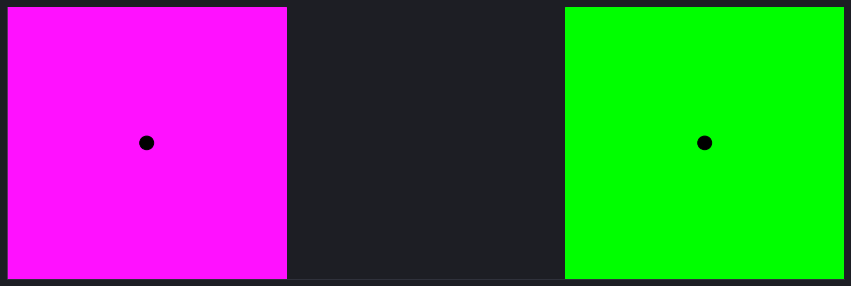

In [301]:
from matplotlib.patches import Rectangle, Circle
fig, ax = plt.subplots(figsize=(15, 5))

ax.add_patch(Rectangle((0, 0), 2, 2, color='#ff11ff'))
ax.add_patch(Circle((1, 1), 0.05, color='black'))
ax.add_patch(Rectangle((4, 0), 2, 2, color='#00ff00'))
ax.add_patch(Circle((5, 1), 0.05, color='black'))
ax.set_xlim(0, 6)
ax.set_ylim(0, 2)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

### HSL Dreams and Messy Realities

Here I've plotted sRGB again, but this time using an attempt at representing them in terms of hue, chroma, and lightness. Note how it is not a cylinder, as you saw previously with the slices. This is the fundamental reality that makes working with color hard.

**Any color space can only pick one of these:**

1. Clear bounds for each dimension that represent all of the colors we can see or display.
2. Mapping to hue, color, and saturation in a straightforward way.
3. Distances between points reflect distances between colors.

Any attempt to force this shape into a neat cylinder or cone, like HSV and HSL do, will distort the meaning of at least one of hue, saturation, and lightness. HSV thinks that dark purple and white are the same lightness. HSL thinks that bright yellow and dark blue have the same brightness. Both are subtly wrong in other ways due to their simplicity. Furthermore, how we distinguish colors is quite complicated, so trying to make Euclidean distances between colors reflect their actual distances (say, to make an evenly-spaced gradient) generallly means distorting the meaning of chroma or hue.

In [337]:
import plotly.graph_objects as go
import hsluv

import numpy as np
from scipy.spatial import Delaunay

N = 10
r = np.linspace(0, 1, N)
g = np.linspace(0, 1, N)
b = np.linspace(0, 1, N)

r, g, b = np.meshgrid(r, g, b)
r = r.flatten()
g = g.flatten()
b = b.flatten()

rgbs = np.vstack([r, g, b]).T
lchs = rgb2oklch(rgbs)

l, c, h = lchs.T
x = c * np.cos(np.deg2rad(h))
y = c * np.sin(np.deg2rad(h))
z = l

fig = go.Figure(data=[
    go.Mesh3d(
        x=x,
        y=y,
        z=z,        
        vertexcolor=rgbs * 255,
        alphahull=4,
        # hovertext=list(map(str, rgbs * 255))
    )
])
fig.update_scenes(aspectratio=dict(x=0.5, y=0.5, z=0.8))
fig.update_layout(width=600, height=1000, title='sRGB Space (Hue-Chroma-Lightness)', title_x=0.5, margin=dict(t=30, r=0, l=0, b=0))
fig.show()

## Building a Toolbox

So there isn't any holy grail of color spaces that will perfectly fit our needs. Instead, we'll need to convert between different color spaces that make different sacrifices. Let's start building that toolbox of color spaces.

### LCH Spaces

There are many spaces that attempt to define colors in terms of lightness, chroma, and hue. They all have different tradeoffs and different problems (we didn't evolve to make things easy mathematically), but there are several that are generally pretty good. I will use *Oklch*, an "ok" LCH space. The creator demonstrates it [here](https://bottosson.github.io/posts/oklab/), if you want more details or to compare it against other spaces yourself. We'll call this good enough: it's what I've been using to make the above graphs, so if those felt pretty good to you then you can hopefully trust the math behind it.

Oklch has no clearly defined bound for chroma, and it's not perfect with color distances. But it's generally quite good at tasks like "convert this image to black and white", "saturate this image", or "make the image bluer" while being relatively simple. (It's also included in modern browsers, which is very convenient.)

I'll also refer you to a [nice color picker for Oklch](https://oklch.evilmartians.io) which gives you a sense of how it works.

### Uniform Color Spaces

Sometimes we care a lot about the distance between colors. For example, you might want to make sure that a color on your wall in a certain lighting environment will match the test swatch you were given, to within a specified tolerance. Or you want to make sure that two colors are distinguishable in a graph. 

This is the job of a *uniform color space*. Its job is to match distances between points in space to how close they look to humans. They tend to be very algebraically messy, with many small adjustments for quirks of the visual system and no easy bounds, and don't preserve hue/chroma/lightness as much as spaces like Oklch. But they're excellent for color distances.

We'll use [CAM16-UCS](https://onlinelibrary.wiley.com/doi/full/10.1002/col.22131), a uniform color space designed in 2016. It's the current state of the art in color difference estimation. I've displayed the sRGB gamut in this space opposite. Note how blue gets more real estate than green or red: this makes hue estimation harder but accounts for our extra sensitivity to those colors. Also note how the space is pretty odd-shaped.

In [338]:
import plotly.graph_objects as go
import hsluv
import colour

import numpy as np

N = 10
r = np.linspace(0, 1, N)
g = np.linspace(0, 1, N)
b = np.linspace(0, 1, N)

r, g, b = np.meshgrid(r, g, b)
r = r.flatten()
g = g.flatten()
b = b.flatten()

rgbs = np.vstack([r, g, b]).T
with colour.utilities.suppress_warnings():
    lchs = np.array([colour.convert(rgb, 'sRGB', 'CAM16UCS') for rgb in rgbs])

x, y, z = lchs.T

fig = go.Figure(data=[
    go.Mesh3d(
        x=x,
        y=y,
        z=z,        
        vertexcolor=rgbs * 255,
        alphahull=4,
        # hovertext=list(map(str, rgbs * 255))
    )
])
fig.update_scenes(aspectratio=dict(x=0.5, y=0.5, z=0.8))
fig.update_layout(width=600, height=1000, title='sRGB Space (CAM16-UCS)', title_x=0.5, margin=dict(t=30, r=0, l=0, b=0))
fig.show()

## Summary: Color in Three Ways

To summarize, we can think of color in three different ways:

 - As a color produced on a computer screen—intensities of red, green, and blue.
 - As a combination of hue, saturation, and lightness.
 - As a point in 3D space with meaningful distances between other points.

Generally, getting all three of these at once is impossible. By converting from space to space, however, we can optimize our programs to match how humans see color, not just how computers display it. Some example scenarios where using one of these more sophisticated spaces might make sense:

 - If you're trying to generate a color scheme from an image by clustering the colors together, consider using a uniform color space to do that clustering.
 - If you're building a website and checking for accessibility requirements, use a good definition of lightness to make sure that your content has sufficient contrast.

A specific application I've employed these spaces in is developing a set of aesthetics for data visualization. Stay tuned for more on that journey.

## Selecting Categorical Colors

Now we move from theory to practice. Let's say you're going to make a graph with twelve lines representing, say, the different months of the year. You'd like each line to be distinguishable from the others at a glance. Additionally, we'd like all of the colors to be visible on a dark or light background, so they can't be too dark or light themselves. This is the problem we're going to tackle with our new tools.

We have three spaces we can convert between as required
 - sRGB, the final output and the limits on our color choices.
 - Oklch, which lets us specify colors in familiar terms.
 - CAM16UCS, which gives us accurate color difference information.

People have tried a lot of methods to produce these color sets. Try to think of what you might consider right now, before you see my solution.

Text(0.5, 1.0, 'Number of Airline Passengers By Year and Month')

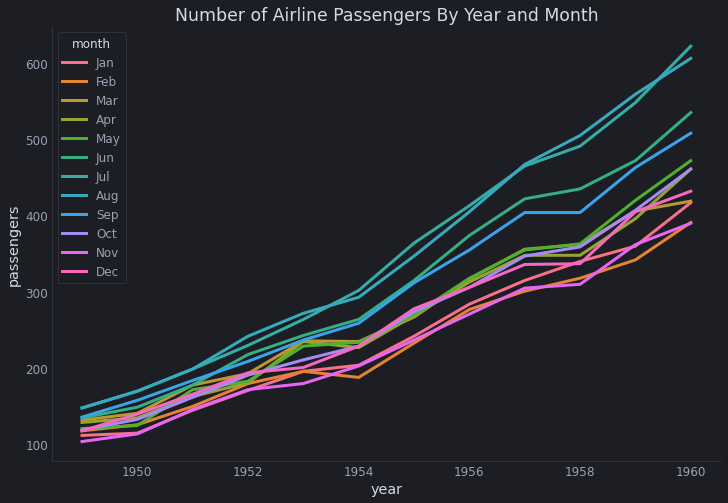

In [317]:
flights = sns.load_dataset('flights')
flights

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=flights, x='year', hue='month', y='passengers', ax=ax, palette='husl')
ax.set_title('Number of Airline Passengers By Year and Month')

### Reinventing the Wheel

What the plotting library `seaborn` does by default for 12 colors, as you saw previously, is simply take evenly-spaced colors with a specified hue and the maximum chroma available at a given lightness. This can easily be modified to produce however many colors you want, and by setting the lightness we can make sure it works on dark or light backgrounds. However, it has a disadvantage: we're wasting space. Varying lightness and chroma lets us produce colors that are farther away from each other. Once you get to 12 colors using a color wheel, it starts to become difficult to tell consecutive colors apart at small sizes.

I've plotted the twelve colors seaborn uses here. The uneven spacing is fixable (the color space seaborn uses isn't as precise as CAM16-UCS about color difference and specifically the idiosyncrasies of blue and green), but the fact that we're not using the available space on the other axes isn't.

We're going to try other approaches, but I don't want to be too harsh. This is a pretty solid system for generating palettes with arbitrary numbers of colors, which is a very hard problem for which even passable solutions are appreciated. But there are better ways to pick a bespoke set of colors.

In [335]:
import plotly.graph_objects as go
import hsluv
import colour

import numpy as np

N = 10
r = np.linspace(0, 1, N)
g = np.linspace(0, 1, N)
b = np.linspace(0, 1, N)

r, g, b = np.meshgrid(r, g, b)
r, g, b = np.array(sns.color_palette('husl', 12)).T
r = r.flatten()
g = g.flatten()
b = b.flatten()

rgbs = np.vstack([r, g, b]).T
with colour.utilities.suppress_warnings():
    lchs = np.array([colour.convert(rgb, 'sRGB', 'CAM16UCS') for rgb in rgbs])

x, y, z = lchs.T

fig = go.Figure(data=[
    go.Scatter3d(
        x=x,
        y=y,
        z=z,        
        marker=dict(color=rgbs * 255, size=15),
        mode='markers'
    )
])
fig.update_scenes(aspectratio=dict(x=0.7, y=0.7, z=0.7))
fig.update_layout(width=600, height=1000, title='Color Wheel Palette (CAM16-UCS)', title_x=0.5, margin=dict(t=30, r=0, l=0, b=0))
fig.show()